# The Flowers Dataset

$\textbf{About the Dataset}$

 The dataset contains 3670 raw jpeg images of five types of flowers:
- daisy
- dandelion
- rose
- sunflower
- tulip


In the associated folder one will find five folders namely - 'daisy', 'dandelion', 'rose', 'sunflower' and 'tulip' which contain the images of the respective flowers. In this notebook our goal will be to build a neural network from scratch, and then finetune it to improve the model.

In [1]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import random as python_random
from tensorflow.keras.applications import VGG16
from keras import layers, models
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Loading dataset

In [2]:
drive.mount('/content/gdrive')
# Path to your .tgz file
file_path = 'gdrive/My Drive/Colab Notebooks/flower_photos.tgz'

# Extract the contents
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/content/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
batch_size = 32
img_height = 224
img_width = 224

def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=(224, 224)) # change image size from original to make them of same shape
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data('flower_photos')

Class names: ['roses', 'daisy', 'sunflowers', 'dandelion', 'tulips']


# Preprocessing


In [4]:
def split_data(X, y, train_size, val_size, test_size, random_state=None):

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)
    remaining_proportion = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
# Normalize data first:

X_normalized = X/255.

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [7]:
# Delete unused data, to prevent RAM from going boom

del(X)
del(X_normalized)

GRADCAM VISUALIZATION

In [8]:
# for the moment fix LR and epochs


n_classes = 5

In [9]:
y_test_encoded = to_categorical(y_test, n_classes)

In [43]:

# Load the model from Google Drive
model_load_path = 'gdrive/My Drive/Colab Notebooks/flower_classification_AUG_model.h5'
loaded_model = tf.keras.models.load_model(model_load_path)

In [44]:
# Print model summary
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)       

In [12]:
print(loaded_model.evaluate(X_test, y_test_encoded))

12/12 [==============================] - 5s 422ms/step - loss: 9.3794 - accuracy: 0.1880
[9.379373550415039, 0.18801090121269226]


In [45]:
last_conv_layer_name = "conv2d_11"  #look at model.summary if mismatched
img_size=(224,224)

In [46]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [47]:
loaded_model.layers[-1].activation = None

In [70]:
idx=10
testimage = X_test[idx]
testimage = testimage[np.newaxis,:,:]

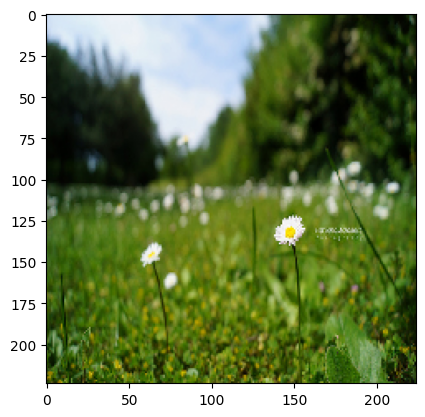

In [71]:
plt.imshow((X_test[idx]*255).astype("uint8"))


In [72]:
preds = loaded_model.predict(testimage)
print("Predicted:", preds)

1/1 [==============================] - 0s 40ms/step
Predicted: [[-3.6316373  -1.9872832   0.26204255 -4.959526    3.6955636 ]]


In [73]:
heatmap = make_gradcam_heatmap(testimage, loaded_model, last_conv_layer_name)

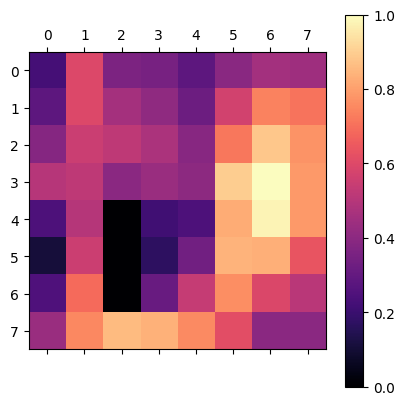

In [85]:
plt.matshow(heatmap, cmap="magma")
plt.colorbar()
plt.show()

#VISUALIZATION ON IMAGE


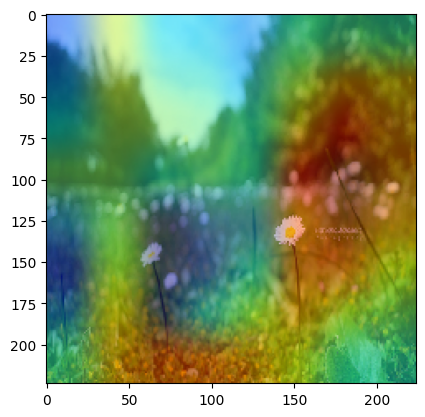

In [93]:
import matplotlib as mpl
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255*heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[1]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = superimposed_img[0]
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)


display_gradcam(testimage*255, heatmap, alpha=0.8)